## 0. Import Libraries & Environment Setup

Trong cell này, nhóm tiến hành import toàn bộ các thư viện cần thiết cho pipeline xử lý ảnh và huấn luyện mô hình.  
Các thư viện được chia thành các nhóm theo chức năng để đảm bảo tính rõ ràng và dễ bảo trì.

### 🔹 Thư viện hệ thống & xử lý dữ liệu
- `os`, `glob`, `random`: thao tác với file system, duyệt thư mục và đảm bảo tính ngẫu nhiên.
- `numpy`: xử lý mảng số học và dữ liệu đặc trưng.

### 🔹 Thư viện xử lý ảnh
- `cv2` (OpenCV): đọc, resize và tiền xử lý ảnh.
- `matplotlib.pyplot`: trực quan hoá ảnh và kết quả trung gian.

### 🔹 Machine Learning (scikit-learn)
- `train_test_split`, `StratifiedKFold`: chia dữ liệu và cross-validation có cân bằng lớp.
- `make_pipeline`: xây dựng pipeline tiền xử lý và mô hình.
- `StandardScaler`: chuẩn hoá đặc trưng trước khi huấn luyện.
- `SVC`, `SGDClassifier`: các classifier cổ điển phù hợp với HOG feature.
- `accuracy_score`, `classification_report`, `confusion_matrix`, `log_loss`: đánh giá hiệu năng mô hình.
- `shuffle`: xáo trộn dữ liệu nhằm tránh bias theo thứ tự.

### 🔹 Lưu & tải mô hình
- `joblib`: lưu trữ và load mô hình đã huấn luyện.

### 🔹 Deep Learning (so sánh / mở rộng)
- `tensorflow`, `VGG16`, `preprocess_input`: phục vụ baseline hoặc so sánh với mô hình deep learning pretrained.

### 🔹 Trích xuất đặc trưng
- `hog` (scikit-image): trích xuất Histogram of Oriented Gradients – đặc trưng chính được sử dụng trong bài toán.


In [8]:

# =========================
# 0) IMPORTS (1 cell duy nhất)
# =========================
import os, glob, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.utils import shuffle

import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from skimage.feature import hog


## 1. Configuration & Experimental Setup

Cell này dùng để thiết lập toàn bộ các tham số cấu hình cố định cho thí nghiệm nhằm đảm bảo **tính tái lập (reproducibility)** và **dễ điều chỉnh khi chạy trên môi trường khác**.

### 🔹 Dataset configuration
- `DATASET_ROOT`: đường dẫn tới dataset **LISA Traffic Light Dataset** (phiên bản Kaggle).
- Việc tách riêng đường dẫn giúp dễ dàng chuyển đổi môi trường (local / Colab / máy khác) mà không ảnh hưởng logic code.

### 🔹 Experimental control
- `RANDOM_SEED = 42`: cố định seed để đảm bảo kết quả huấn luyện có thể tái lập.
- `TEST_SIZE = 0.2`: chia dữ liệu theo tỷ lệ 80% train – 20% test.
- `MAX_SAMPLES = 8000`: giới hạn số lượng mẫu để cân bằng giữa chi phí tính toán và độ đa dạng dữ liệu.

### 🔹 Label mapping
- `LABEL_MAP`: ánh xạ nhãn gốc của dataset sang chỉ số số nguyên phục vụ huấn luyện.
- `ID2NAME`: ánh xạ ngược từ nhãn số sang tên lớp, dùng cho trực quan hoá và báo cáo kết quả.

### 🔹 Output & environment check
- Tạo thư mục `outputs/` để lưu model, biểu đồ và kết quả trung gian.
- In ra:
  - Phiên bản TensorFlow
  - Trạng thái GPU
  - Đường dẫn dataset  
→ giúp kiểm tra nhanh môi trường chạy trước khi huấn luyện.

Việc gom toàn bộ cấu hình vào một cell duy nhất giúp pipeline rõ ràng, dễ bảo trì và thuận tiện cho việc mở rộng thí nghiệm.


In [ ]:

# =========================
# 1) CONFIG
# =========================
DATASET_ROOT = r"C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2"  # <-- sửa path này

RANDOM_SEED = 42
TEST_SIZE = 0.2
MAX_SAMPLES = 20000

LABEL_MAP = {0: "other", 1: "green", 2: "red", 3: "yellow"}
ID2NAME = {1: "green", 2: "red", 3: "yellow"}

os.makedirs("outputs", exist_ok=True)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))
print("DATASET_ROOT:", DATASET_ROOT)


TensorFlow: 2.20.0
GPU available: False
DATASET_ROOT: C:\Users\PC\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2


## 2. Reproducibility, Feature Extractors & Training Utilities

Cell này định nghĩa các hàm tiện ích cốt lõi cho toàn bộ pipeline, bao gồm:  
**cố định seed**, **load dữ liệu**, **trích xuất đặc trưng (HOG & VGG16)** và **huấn luyện – đánh giá mô hình SVM**.

---

### 🔹 Reproducibility
Hàm `seed_everything()` được sử dụng để cố định seed cho:
- `random`
- `numpy`
- `tensorflow`  

Nhằm đảm bảo kết quả huấn luyện có thể tái lập giữa các lần chạy và trên các môi trường khác nhau.

---

### 🔹 Dataset loader
- Import hàm `build_patch_dataset_from_box_csvs` từ file `dataset_lisa.py`.
- Hàm này xây dựng tập dữ liệu patch ảnh (64×64) dựa trên bounding box annotation từ file CSV của dataset LISA.

→ Thiết kế tách riêng phần load dữ liệu giúp code gọn gàng và dễ tái sử dụng.

---

### 🔹 Handcrafted feature: HOG
- Import `hog_batch` từ file `features_hog.py`.
- Hàm này trích xuất HOG feature theo batch nhằm tối ưu tốc độ và bộ nhớ.
- HOG được sử dụng như đặc trưng chính cho bài toán phân loại đèn giao thông.

---

### 🔹 Deep feature extractor: VGG16
Định nghĩa bộ trích xuất đặc trưng deep learning để **so sánh với HOG**:

- Sử dụng VGG16 pretrained trên ImageNet.
- Bỏ tầng phân loại (`include_top=False`).
- Áp dụng `GlobalAveragePooling2D` để thu được vector đặc trưng cố định cho mỗi patch.

Hàm `vgg16_features()` thực hiện:
- Chuẩn hoá input theo chuẩn ImageNet.
- Trích xuất feature theo batch.
- Trả về vector đặc trưng dạng `float32`.

---

### 🔹 Model training & evaluation
Hàm `train_eval_svm()`:
- Xây dựng pipeline gồm:
  - `StandardScaler`: chuẩn hoá đặc trưng
  - `SVC (RBF kernel)`: phân loại đa lớp
- Huấn luyện trên tập train và đánh giá trên tập test.
- Báo cáo:
  - Accuracy
  - Confusion matrix
  - Classification report (precision / recall / F1-score)
- Lưu mô hình bằng `joblib` để tái sử dụng.

---

### 🔹 Visualization
Hàm `plot_confmat()` dùng để:
- Trực quan hoá confusion matrix
- Hiển thị số lượng dự đoán đúng/sai cho từng lớp  
→ hỗ trợ phân tích lỗi mô hình một cách trực quan.

Cell này đóng vai trò như **thư viện hàm nội bộ**, giúp pipeline chính phía sau ngắn gọn, rõ ràng và dễ mở rộng.


In [10]:

# =========================
# 2) HELPERS
# =========================
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        tf.random.set_seed(seed)
    except Exception:
        pass

seed_everything(RANDOM_SEED)

# --- dataset loader (từ file dataset_lisa.py bạn đã có) ---
from dataset_lisa import build_patch_dataset_from_box_csvs

# --- HOG feature extractor (từ file features_hog.py bạn đã có) ---
from features_hog import hog_batch

def build_vgg16_feature_extractor():
    base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
    model = tf.keras.Sequential([base, tf.keras.layers.GlobalAveragePooling2D()])
    return model

def vgg16_features(model, X_patches_uint8, batch_size=64):
    X = X_patches_uint8.astype(np.float32)
    X = preprocess_input(X)
    feats = model.predict(X, batch_size=batch_size, verbose=1)
    return feats.astype(np.float32)

def train_eval_svm(X_train, y_train, X_test, y_test, out_path):
    svm = make_pipeline(
        StandardScaler(),
        SVC(C=1.0, kernel="rbf", probability=True)
    )
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)

    acc = accuracy_score(y_test, pred)
    print("Accuracy:", acc)
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, target_names=[LABEL_MAP[i] for i in sorted(set(y_test))]))

    joblib.dump(svm, out_path)
    print("Saved:", out_path)
    return svm, acc

def plot_confmat(cm, class_names, title):
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()


## 3. Load Patch Dataset from Bounding-Box Annotations

Trong cell này, nhóm xây dựng tập dữ liệu huấn luyện theo dạng **image patches (cropped regions)** dựa trên bounding-box annotations của bộ dữ liệu LISA.

### 🔹 Mục tiêu
- Chuyển bài toán từ *detection* (tìm vị trí đèn trong ảnh lớn) sang *classification* trên các patch đã được crop.
- Mỗi patch tương ứng một vùng chứa đèn giao thông, kèm nhãn màu (green/red/yellow) hoặc lớp khác nếu có.

### 🔹 Quy trình thực hiện
1. **Build dataset từ annotation**
   - Gọi `build_patch_dataset_from_box_csvs(DATASET_ROOT, max_samples=MAX_SAMPLES)` để:
     - đọc thông tin bounding box từ các file annotation (CSV)
     - crop vùng ảnh tương ứng bounding box
     - chuẩn hoá patch về kích thước thống nhất (dùng cho trích xuất feature và mô hình)

2. **Kiểm tra kích thước dữ liệu**
   - In ra `X_patches.shape` và `y.shape` để đảm bảo số lượng patch và nhãn khớp nhau.

3. **Thống kê phân phối nhãn**
   - Dùng `np.unique(..., return_counts=True)` để kiểm tra class imbalance.
   - Thông tin này rất quan trọng vì ảnh hưởng trực tiếp đến độ tin cậy của accuracy và các metric (precision/recall).

4. **Trực quan hoá nhanh một vài patch**
   - Hiển thị tối đa 12 patch đầu tiên kèm tên nhãn.
   - Mục đích:
     - sanity check: patch có đúng là vùng chứa đèn không
     - kiểm tra chất lượng crop và độ nhiễu trong dữ liệu

Cell này đảm bảo dữ liệu đầu vào đã được xây dựng đúng trước khi chuyển sang bước trích xuất đặc trưng (HOG/VGG16) và huấn luyện mô hình.


Building dataset from LISA annotations...
Patches: (8000, 64, 64, 3) Labels: (8000,)
Label distribution:
1 green : 4719
2 red : 2989
3 yellow : 292


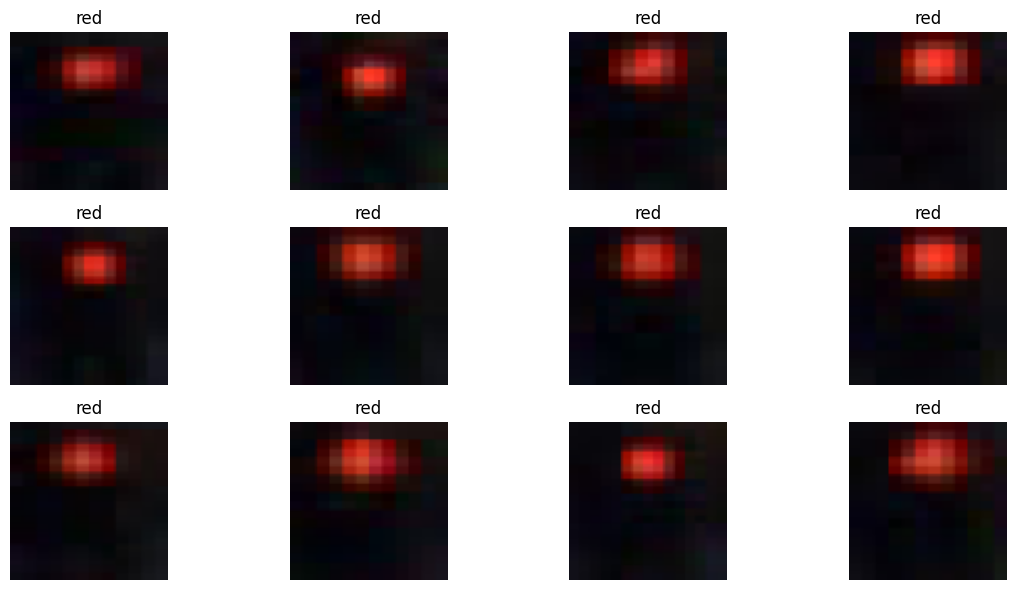

In [11]:

# =========================
# 3) LOAD PATCH DATASET (from BOX annotations)
# =========================
print("Building dataset from LISA annotations...")
X_patches, y = build_patch_dataset_from_box_csvs(DATASET_ROOT, max_samples=MAX_SAMPLES)

print("Patches:", X_patches.shape, "Labels:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:")
for u, c in zip(unique, counts):
    print(u, LABEL_MAP.get(int(u), str(u)), ":", int(c))

# quick visualize
nshow = min(12, len(X_patches))
plt.figure(figsize=(12, 6))
for i in range(nshow):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_patches[i])
    plt.title(LABEL_MAP[int(y[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


## 4. Visualize HOG Hyperparameters (Cell size, Block size)

Trong cell này, nhóm trực quan hoá ảnh HOG tương ứng với nhiều cấu hình tham số khác nhau nhằm **giải thích lựa chọn HOG(4,2)** một cách định tính.

### 🔹 Mục tiêu
- Kiểm tra mức độ giữ chi tiết biên (edge) của từng cấu hình HOG trên cùng một patch.
- Quan sát trade-off giữa:
  - **cell lớn** → đặc trưng thô, dễ mất chi tiết đối tượng nhỏ
  - **cell nhỏ** → đặc trưng chi tiết hơn nhưng có thể nhiễu và tăng chiều đặc trưng
- Từ đó chọn cấu hình phù hợp nhất cho patch đèn giao thông (đối tượng nhỏ, nhiều edge).

### 🔹 Cách thực hiện
1. Chuyển ảnh patch từ RGB sang grayscale (HOG thường áp dụng trên ảnh xám).
2. Thử nhiều cấu hình `configs = [(8,2), (6,4), (10,2), (11,2), (4,2)]`:
   - `pixels_per_cell = (cell, cell)`: kích thước cell
   - `cells_per_block = (block, block)`: kích thước block (dùng để chuẩn hoá cục bộ)
   - `orientations = 9`, `block_norm = 'L2-Hys'`
3. Với mỗi cấu hình, vẽ ảnh HOG (`visualize=True`) để so sánh trực quan.

### 🔹 Ý nghĩa khi báo cáo
- Đây là bước **sanity check** và **giải thích lựa chọn tham số**:  
  cấu hình phù hợp sẽ làm nổi bật rõ ràng cấu trúc biên của đèn (cụm đèn + viền housing) mà không bị quá thô hoặc quá nhiễu.

Kết quả trực quan hoá này hỗ trợ lập luận: **HOG(4,2)** là một điểm cân bằng hợp lý cho patch kích thước nhỏ (64×64), vừa đủ chi tiết để bắt cạnh, vừa đủ ổn định nhờ block normalization.


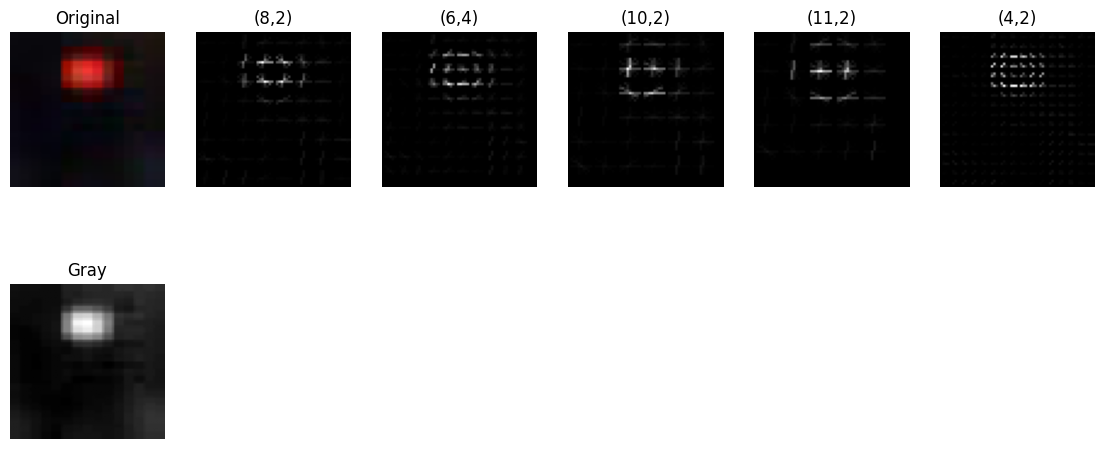

In [12]:
def visualize_hog_params(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    configs = [(8,2),(6,4),(10,2),(11,2),(4,2)]


    plt.figure(figsize=(14,6))
    plt.subplot(2, len(configs)+1, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')


    plt.subplot(2, len(configs)+1, len(configs)+2)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Gray")
    plt.axis('off')


    for i,(cell,block) in enumerate(configs):
        _, hog_img = hog(img_gray, orientations=9,
        pixels_per_cell=(cell,cell),
        cells_per_block=(block,block),
        visualize=True, block_norm='L2-Hys')
        plt.subplot(2, len(configs)+1, i+2)
        plt.imshow(hog_img, cmap='gray')
        plt.title(f"({cell},{block})")
        plt.axis('off')
    plt.show()


visualize_hog_params(X_patches[10])

## 5. Train/Test Split (Stratified)

Cell này thực hiện bước chia dữ liệu thành tập **train** và **test** để đánh giá mô hình một cách khách quan.

### 🔹 Mục tiêu
- Tách dữ liệu thành 2 phần độc lập:
  - **Train set**: dùng để học tham số mô hình
  - **Test set**: dùng để đánh giá khả năng tổng quát hoá (generalization)

### 🔹 Thiết lập quan trọng
- `test_size = TEST_SIZE` (ví dụ 0.2): giữ lại 20% dữ liệu để test.
- `random_state = RANDOM_SEED`: đảm bảo kết quả chia dữ liệu có thể tái lập.
- `stratify = y`: **chia theo stratified split** để tỉ lệ các lớp (green/red/yellow/other) trong train và test được giữ tương tự nhau.

### 🔹 Vì sao cần stratify?
Do dữ liệu thường bị **mất cân bằng lớp (class imbalance)**, nếu chia ngẫu nhiên không stratify có thể dẫn đến:
- một lớp bị thiếu nghiêm trọng trong tập train hoặc test
- metric bị sai lệch, đánh giá không đáng tin

Cell này in ra kích thước train/test để kiểm tra nhanh rằng việc chia dữ liệu đã diễn ra đúng.


In [ ]:

# =========================
# 4) TRAIN/TEST SPLIT 
# =========================
X_train_p, X_test_p, y_train, y_test = train_test_split(
    X_patches, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train patches:", X_train_p.shape, "Test patches:", X_test_p.shape)


Train patches: (6400, 64, 64, 3) Test patches: (1600, 64, 64, 3)


## 6. HOG Feature Extraction

Trong cell này, nhóm trích xuất **Histogram of Oriented Gradients (HOG)** từ các patch ảnh trong tập train và test để chuyển dữ liệu ảnh sang dạng vector đặc trưng phục vụ huấn luyện mô hình cổ điển.

### 🔹 Mục tiêu
- Biểu diễn mỗi patch ảnh bằng vector đặc trưng dựa trên **hướng và cường độ gradient**.
- Giảm độ phức tạp của dữ liệu ảnh thô trong khi vẫn giữ lại thông tin hình dạng và biên — rất quan trọng đối với đèn giao thông.

### 🔹 Cách thực hiện
- Sử dụng hàm `hog_batch()` (định nghĩa trong `features_hog.py`) để:
  - xử lý theo batch nhằm tối ưu tốc độ
  - đảm bảo cấu hình HOG nhất quán giữa train và test
- HOG được trích xuất **sau khi chia train/test** nhằm tránh data leakage.

### 🔹 Kiểm tra đầu ra
- In ra kích thước của:
  - `X_train_hog`
  - `X_test_hog`
- Mỗi hàng tương ứng với một patch ảnh, mỗi cột là một thành phần của vector HOG.

### 🔹 Ý nghĩa trong pipeline
- Đây là bước chuyển đổi từ **image space → feature space**.
- Chất lượng của HOG feature quyết định trực tiếp hiệu năng của classifier phía sau (SVM).

Cell này chuẩn bị dữ liệu đầu vào cho bước huấn luyện và đánh giá mô hình phân loại.


In [14]:

# =========================
# 5) HOG FEATURES
# =========================
X_train_hog = hog_batch(X_train_p)
X_test_hog = hog_batch(X_test_p)

print("HOG train feat:", X_train_hog.shape, "HOG test feat:", X_test_hog.shape)


HOG train feat: (6400, 5400) HOG test feat: (1600, 5400)


## 7. Train & Evaluate SVM using HOG Features

Trong cell này, nhóm huấn luyện và đánh giá mô hình **Support Vector Machine (SVM)** sử dụng đặc trưng **HOG** đã trích xuất từ các patch ảnh.

### 🔹 Mô hình sử dụng
- **Pipeline** gồm:
  - `StandardScaler`: chuẩn hoá đặc trưng HOG (rất quan trọng với SVM).
  - `SVC` với **RBF kernel**: mô hình phân loại phi tuyến, phù hợp với đặc trưng HOG có phân bố phức tạp.
- Tham số chính:
  - `C = 1.0`
  - `probability = True` (phục vụ phân tích và mở rộng sau này).

### 🔹 Huấn luyện & đánh giá
- Mô hình được huấn luyện trên tập train và đánh giá trên tập test độc lập.
- Các metric được báo cáo:
  - **Accuracy**
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score cho từng lớp)

### 🔹 Lưu mô hình
- Mô hình đã huấn luyện được lưu lại bằng `joblib` (`svm_hog.joblib`) để tái sử dụng cho inference hoặc demo.

### 🔹 Phân tích lỗi
- Confusion Matrix được trực quan hoá nhằm:
  - xác định các cặp lớp dễ bị nhầm lẫn (ví dụ: red vs yellow)
  - hỗ trợ phân tích nguyên nhân sai sót của mô hình

Cell này hoàn thiện pipeline phân loại **HOG → SVM**, đóng vai trò baseline cổ điển cho bài toán nhận dạng đèn giao thông.


Accuracy: 0.99625
Confusion matrix:
 [[942   2   0]
 [  3 595   0]
 [  0   1  57]]
              precision    recall  f1-score   support

       green       1.00      1.00      1.00       944
         red       0.99      0.99      0.99       598
      yellow       1.00      0.98      0.99        58

    accuracy                           1.00      1600
   macro avg       1.00      0.99      0.99      1600
weighted avg       1.00      1.00      1.00      1600

Saved: outputs/svm_hog.joblib


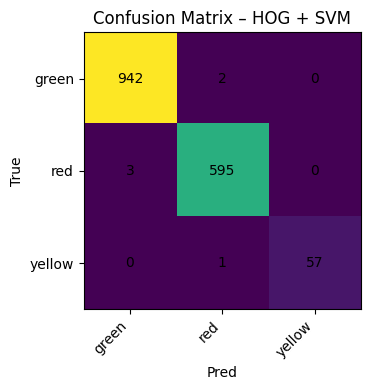

In [15]:

# =========================
# 6) TRAIN + EVAL SVM (HOG)
# =========================
svm_hog, acc_hog = train_eval_svm(
    X_train_hog, y_train,
    X_test_hog, y_test,
    out_path="outputs/svm_hog.joblib"
)

cm = confusion_matrix(y_test, svm_hog.predict(X_test_hog))
class_names = [LABEL_MAP[i] for i in sorted(np.unique(y))]
plot_confmat(cm, class_names, "Confusion Matrix – HOG + SVM")


## 8. Deep Feature Extraction using VGG16 (Frozen)

Trong cell này, nhóm sử dụng **VGG16 pretrained trên ImageNet** như một **bộ trích xuất đặc trưng sâu (deep feature extractor)** để so sánh với đặc trưng thủ công HOG.

### 🔹 Mục tiêu
- Khai thác các đặc trưng học được từ mạng CNN sâu mà không cần huấn luyện lại toàn bộ mô hình.
- Thiết lập một baseline deep feature nhằm so sánh hiệu quả với phương pháp HOG + SVM.

### 🔹 Thiết lập mô hình
- Sử dụng **VGG16 pretrained** (`weights = "imagenet"`).
- Loại bỏ tầng phân loại cuối (`include_top = False`).
- Áp dụng **Global Average Pooling** để chuyển feature map thành vector đặc trưng cố định.
- Toàn bộ backbone được **freeze** (không fine-tune) nhằm:
  - tránh overfitting với dataset nhỏ
  - giảm chi phí tính toán
  - tập trung vào so sánh đặc trưng thay vì huấn luyện CNN

### 🔹 Trích xuất đặc trưng
- Ảnh đầu vào được chuẩn hoá bằng `preprocess_input` theo chuẩn ImageNet.
- Feature được trích xuất theo batch (`batch_size = 64`) để tối ưu bộ nhớ và tốc độ.
- Đầu ra là vector đặc trưng `float32` cho mỗi patch ảnh.

### 🔹 Ý nghĩa trong pipeline
- Thiết lập một phương pháp **deep feature + classical classifier** (VGG16 + SVM).
- Cho phép đánh giá liệu đặc trưng học sâu có mang lại lợi thế so với HOG trong bối cảnh dataset nhỏ và đối tượng chuyên biệt (đèn giao thông).

Cell này chuẩn bị dữ liệu đầu vào cho bước huấn luyện và đánh giá mô hình SVM với đặc trưng VGG16.


In [16]:

# =========================
# 7) VGG16 (freeze) FEATURES
# =========================
print("Loading VGG16 feature extractor (freeze)...")
vgg_model = build_vgg16_feature_extractor()

X_train_vgg = vgg16_features(vgg_model, X_train_p, batch_size=64)
X_test_vgg  = vgg16_features(vgg_model, X_test_p, batch_size=64)

print("VGG train feat:", X_train_vgg.shape, "VGG test feat:", X_test_vgg.shape)


Loading VGG16 feature extractor (freeze)...
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 327ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step
VGG train feat: (6400, 512) VGG test feat: (1600, 512)


## 9. Train & Evaluate SVM using VGG16 (Frozen) Features

Trong cell này, nhóm huấn luyện và đánh giá mô hình **SVM** nhưng thay vì dùng HOG, đầu vào là **deep features** trích xuất từ **VGG16 pretrained (freeze)**.

### 🔹 Mục tiêu
- So sánh hiệu năng giữa:
  - **HOG + SVM** (handcrafted features)
  - **VGG16(freeze) + SVM** (deep features)
- Đánh giá khả năng tổng quát hoá của đặc trưng deep learning trong bối cảnh dataset chuyên biệt và kích thước vừa/nhỏ.

### 🔹 Huấn luyện & đánh giá
- Sử dụng lại hàm `train_eval_svm()` để đảm bảo quy trình huấn luyện/đánh giá nhất quán:
  - chuẩn hoá đặc trưng bằng `StandardScaler`
  - SVM với RBF kernel
- Báo cáo các metric:
  - Accuracy
  - Classification Report (Precision / Recall / F1-score)
  - Confusion Matrix

### 🔹 Lưu mô hình
- Lưu mô hình đã huấn luyện vào `outputs/svm_vgg16.joblib` để phục vụ inference/demo và tái lập kết quả.

### 🔹 Phân tích lỗi bằng Confusion Matrix
- Vẽ confusion matrix nhằm:
  - quan sát các lớp dễ bị nhầm lẫn
  - so sánh pattern lỗi với mô hình HOG + SVM
  - xác định xem deep feature giúp giảm nhầm lẫn nào (ví dụ: red ↔ yellow) hay không

Cell này hoàn tất baseline **VGG16(freeze) → feature vector → SVM**, phục vụ so sánh trực tiếp với baseline cổ điển HOG + SVM.


Accuracy: 0.984375
Confusion matrix:
 [[944   0   0]
 [ 19 579   0]
 [  6   0  52]]
              precision    recall  f1-score   support

       green       0.97      1.00      0.99       944
         red       1.00      0.97      0.98       598
      yellow       1.00      0.90      0.95        58

    accuracy                           0.98      1600
   macro avg       0.99      0.95      0.97      1600
weighted avg       0.98      0.98      0.98      1600

Saved: outputs/svm_vgg16.joblib


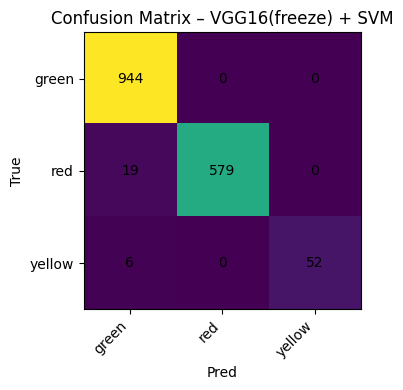

In [17]:

# =========================
# 8) TRAIN + EVAL SVM (VGG16 freeze)
# =========================
svm_vgg, acc_vgg = train_eval_svm(
    X_train_vgg, y_train,
    X_test_vgg, y_test,
    out_path="outputs/svm_vgg16.joblib"
)

cm = confusion_matrix(y_test, svm_vgg.predict(X_test_vgg))
class_names = [LABEL_MAP[i] for i in sorted(np.unique(y))]
plot_confmat(cm, class_names, "Confusion Matrix – VGG16(freeze) + SVM")


## 10. Learning Curve (SVM) – Compare HOG vs VGG16 Features

Trong cell này, nhóm vẽ **learning curve** để phân tích hành vi học của mô hình SVM theo số lượng dữ liệu huấn luyện, đồng thời so sánh giữa 2 loại đặc trưng:
- **HOG + SVM**
- **VGG16(freeze) + SVM**

### 🔹 Mục tiêu
Learning curve giúp trả lời các câu hỏi quan trọng khi đánh giá mô hình:
- Mô hình có **overfitting** không? (train cao, val thấp)
- Mô hình có **underfitting** không? (train và val đều thấp)
- Thêm dữ liệu có giúp cải thiện đáng kể không?
- Feature nào (HOG hay VGG16) cho khả năng tổng quát hoá tốt hơn?

### 🔹 Thiết lập phương pháp
- Classifier cố định: `StandardScaler + SVC(RBF, C=1.0)`
- Cross-validation: `StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)`
  - đảm bảo mỗi fold giữ phân phối nhãn tương tự nhau
  - giảm sai lệch do class imbalance
- `train_sizes`: lấy 8 mức từ 10% → 100% dữ liệu train
- Metric: `accuracy`

### 🔹 Cách đọc biểu đồ
- **Khoảng cách Train acc vs Val acc**:
  - khoảng cách lớn → dấu hiệu overfitting
  - khoảng cách nhỏ nhưng cả hai thấp → underfitting
- **Val curve tăng dần theo train size**:
  - thêm dữ liệu có ích (data-limited regime)
- **Val curve bão hoà sớm**:
  - giới hạn bởi feature/model, cần đổi feature hoặc tune hyperparameters

### 🔹 Ý nghĩa so sánh HOG vs VGG16
Hai learning curve được vẽ với cùng một loại classifier và quy trình CV, nên sự khác biệt chủ yếu phản ánh **chất lượng và độ ổn định của feature representation** (HOG vs deep features).


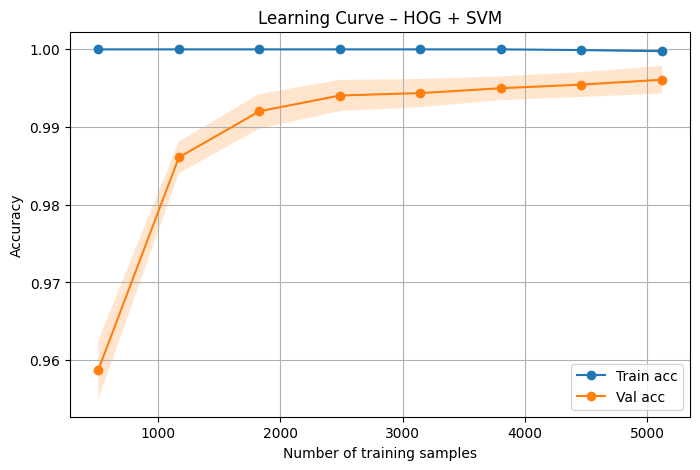

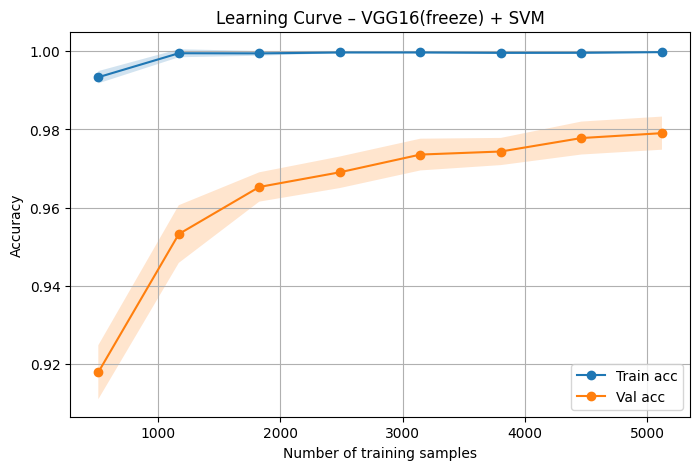

In [18]:

# =========================
# 9) LEARNING CURVE (đúng cho SVM) – so sánh HOG vs VGG
# =========================
def plot_learning_curve_svm(X, y, title):
    clf = make_pipeline(StandardScaler(), SVC(C=1.0, kernel="rbf"))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    train_sizes, train_scores, val_scores = learning_curve(
        clf, X, y,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, marker="o", label="Train acc")
    plt.plot(train_sizes, val_mean, marker="o", label="Val acc")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.title(title)
    plt.xlabel("Number of training samples")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_learning_curve_svm(X_train_hog, y_train, "Learning Curve – HOG + SVM")
plot_learning_curve_svm(X_train_vgg, y_train, "Learning Curve – VGG16(freeze) + SVM")


## 11. Accuracy/Loss vs “Epoch” (Illustration) using SGDClassifier

SVM (đặc biệt với kernel RBF) không huấn luyện theo khái niệm **epoch** như neural network, nên không thể vẽ trực tiếp đường cong *accuracy/loss theo epoch*.  
Vì vậy, trong cell này nhóm sử dụng **SGDClassifier** (tối ưu lặp theo từng epoch) như một mô hình thay thế để **minh hoạ quá trình hội tụ** và so sánh đặc trưng **HOG vs VGG16(freeze)** dưới một thuật toán có tính “epoch-based”.

---

### 🔹 Mục tiêu
- Trực quan hoá:
  - **Accuracy vs Epoch**
  - **Log Loss vs Epoch**
- Phân tích các hiện tượng:
  - hội tụ (convergence)
  - overfitting/underfitting (qua gap train–val)
  - độ ổn định của feature (HOG vs VGG)

---

### 🔹 Thiết lập mô hình
Hàm `train_sgd_with_curves()` thực hiện:
1. **Chuẩn hoá đặc trưng** bằng `StandardScaler` (bắt buộc với SGD).
2. Khởi tạo `SGDClassifier` với:
   - `loss="log_loss"` (logistic regression theo SGD, có thể tính log loss)
   - `learning_rate="constant"`, `eta0=lr`
   - `max_iter=1`, `tol=None`  
   → mỗi vòng lặp `partial_fit()` tương ứng **1 epoch** trên toàn bộ tập train.
3. Mỗi epoch:
   - shuffle dữ liệu train
   - `partial_fit()` thêm một lượt
   - tính **train/val accuracy**
   - tính **train/val log loss** từ `predict_proba()`

---

### 🔹 Vẽ đường cong
Hàm `plot_epoch_curves()` vẽ 2 biểu đồ:
- Accuracy vs Epoch (train & val)
- Loss vs Epoch (train & val)

---

### 🔹 Validation split (phục vụ curve)
Để vẽ epoch curve, nhóm tách thêm một tập validation từ training set:
- `train_test_split(..., test_size=0.2, stratify=y_train)`
→ giúp quan sát rõ generalization theo thời gian huấn luyện.

---

### 🔹 Ý nghĩa so sánh HOG vs VGG16
- Nếu VGG16 feature “dễ học” hơn: val acc tăng nhanh hơn / loss giảm ổn định hơn.
- Nếu HOG feature ổn định hơn: gap train–val nhỏ hơn và curve ít dao động hơn.
- Đây là minh hoạ bổ trợ để hiểu hành vi học theo epoch; kết quả chính vẫn dựa trên pipeline SVM ở các cell trước.


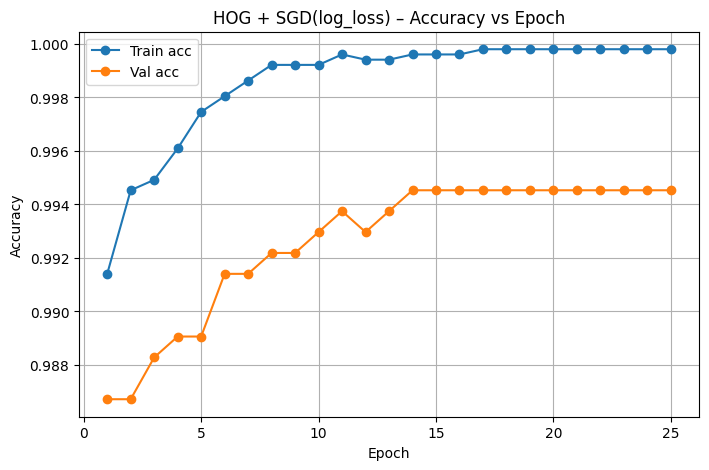

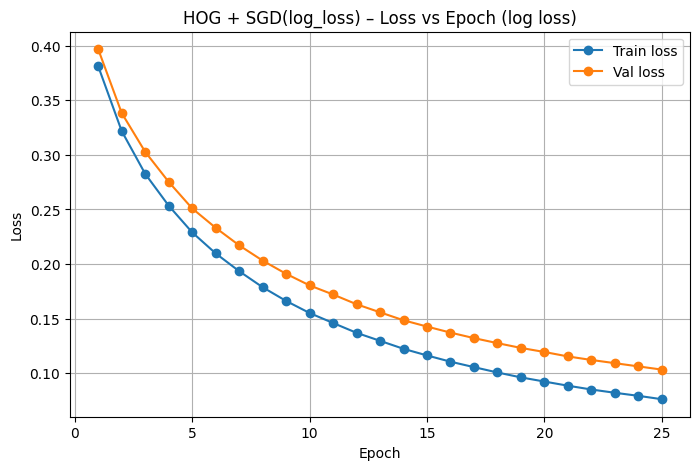

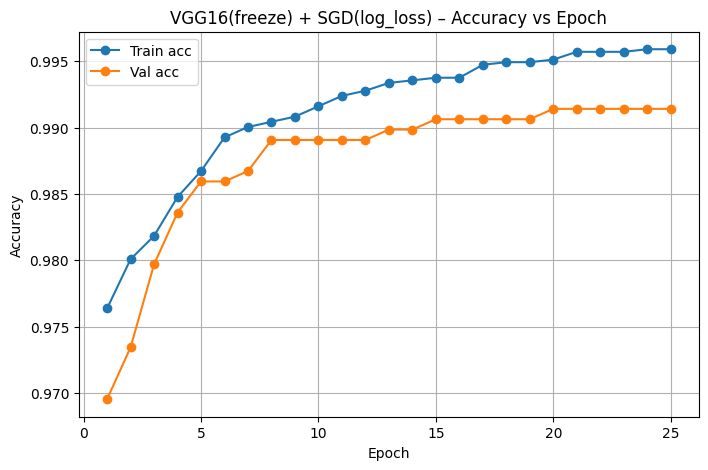

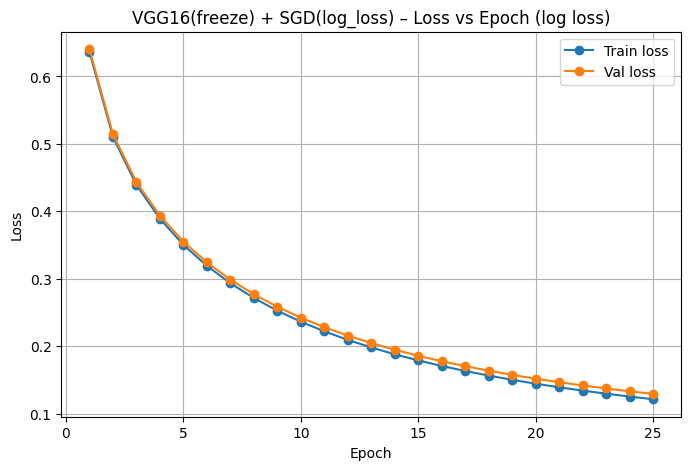

In [ ]:

# =========================
# 10) ACC/LOSS theo "EPOCH" (minh hoạ) – dùng SGDClassifier
# =========================
def train_sgd_with_curves(X_train, y_train, X_val, y_val, epochs=20, lr=1e-4, seed=42):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)

    classes = np.unique(y_train)

    clf = SGDClassifier(
        loss="log_loss",
        learning_rate="constant",
        eta0=lr,
        max_iter=1,
        tol=None,
        random_state=seed
    )

    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for ep in range(epochs):
        X_train_s, y_train = shuffle(X_train_s, y_train, random_state=seed + ep)

        if ep == 0:
            clf.partial_fit(X_train_s, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_s, y_train)

        ytr_pred = clf.predict(X_train_s)
        yva_pred = clf.predict(X_val_s)

        train_acc_hist.append(accuracy_score(y_train, ytr_pred))
        val_acc_hist.append(accuracy_score(y_val, yva_pred))

        ytr_prob = clf.predict_proba(X_train_s)
        yva_prob = clf.predict_proba(X_val_s)

        train_loss_hist.append(log_loss(y_train, ytr_prob, labels=classes))
        val_loss_hist.append(log_loss(y_val, yva_prob, labels=classes))

    return train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

def plot_epoch_curves(train_acc, val_acc, train_loss, val_loss, title_prefix):
    epochs = np.arange(1, len(train_acc)+1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_acc, marker="o", label="Train acc")
    plt.plot(epochs, val_acc, marker="o", label="Val acc")
    plt.title(f"{title_prefix} – Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, marker="o", label="Train loss")
    plt.plot(epochs, val_loss, marker="o", label="Val loss")
    plt.title(f"{title_prefix} – Loss vs Epoch (log loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Tách thêm validation từ train để vẽ curve (epoch)
X_tr_h, X_va_h, y_tr, y_va = train_test_split(
    X_train_hog, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
ta, va, tl, vl = train_sgd_with_curves(X_tr_h, y_tr, X_va_h, y_va, epochs=25, lr=1e-4, seed=RANDOM_SEED)
plot_epoch_curves(ta, va, tl, vl, "HOG + SGD(log_loss)")

X_tr_v, X_va_v, y_tr2, y_va2 = train_test_split(
    X_train_vgg, y_train, test_size=0.2, random_state=RANDOM_SEED, stratify=y_train
)
ta, va, tl, vl = train_sgd_with_curves(X_tr_v, y_tr2, X_va_v, y_va2, epochs=25, lr=1e-4, seed=RANDOM_SEED)
plot_epoch_curves(ta, va, tl, vl, "VGG16(freeze) + SGD(log_loss)")


## 12. Final Stable Demo – Conditioned Sliding Window via S×V Peak (HSV)

Cell này hiện thực một pipeline demo phát hiện đèn giao thông theo hướng **classical + heuristic ổn định**, dựa trên quan sát:  
pixel của đèn (đặc biệt khi đang sáng) thường có **Saturation (S)** và **Value (V)** cao trong không gian HSV.

Thay vì dùng threshold cứng hoặc contour/circularity (dễ vỡ khi thay đổi ánh sáng, nền phức tạp), nhóm chọn cách:
- tìm **điểm “mạnh nhất” theo score = S × V** trong vùng hue phù hợp (đỏ / vàng / xanh)
- sau đó lấy **connected component** chứa điểm đó để có bbox “hợp lý”
- cuối cùng đặt một **sliding window** quanh điểm peak để tạo crop ổn định cho bước phân loại/hiển thị.

---

### 🔹 Ý tưởng chính
1. **Hue gating (lọc theo màu)**
   - Tạo mask theo Hue cho 3 màu: red / yellow / green.
   - Giúp giảm không gian tìm kiếm và tránh nhiễu không liên quan.

2. **Chọn điểm đại diện bằng S×V (bright colored peak)**
   - Trong mask màu, chọn pixel có score cao nhất: `score = S * V`.
   - Làm mượt score bằng Gaussian blur để ổn định peak.
   - Thêm prior theo trục dọc (`y_top_ratio`) để tránh dính các vùng nhiễu ở đáy ảnh.

3. **Lấy bbox từ connected component**
   - Sau khi có điểm peak, lấy bbox của connected component chứa điểm đó.
   - Có mở/giãn hình thái (morphology) để ổn định vùng mask trước khi CC.

4. **Penalty để tránh bbox “dính khung” hoặc quá nhỏ**
   - Nếu component quá lớn (dính biển quảng cáo/đèn xe/khung ảnh) → giảm điểm.
   - Nếu component quá nhỏ (nhiễu điểm sáng) → giảm điểm.
   - Chọn màu có `final_score` cao nhất sau penalty.

5. **Vẽ sliding window quanh peak**
   - Tạo một window kích thước cố định `win_size` quanh peak.
   - Window này đóng vai trò “crop vùng nghi ngờ” ổn định cho demo end-to-end (dễ feed vào classifier).

---

### 🔹 Vì sao cách này ổn định trong thực tế?
- **Không phụ thuộc contour/circularity**: đèn thật có thể bị mờ, bị che, bị flare hoặc méo hình.
- **Không cần threshold cứng quá nhạy**: dùng peak của S×V giúp thích nghi tốt hơn với nhiều điều kiện sáng/tối.
- **Luôn trả về một vùng ứng viên** nếu trong ảnh có vùng màu đủ rõ → phù hợp cho demo realtime / end-to-end.

---

### 🔹 Output demo
- Vẽ bbox component (nếu có) để tham khảo vùng mask theo màu.
- Vẽ sliding window (crop) và gán nhãn màu dự đoán (green/red/yellow).
- `debug=True` in ra thông tin màu được chọn và score để dễ phân tích.

Cell này đóng vai trò **bước detection heuristic ổn định**, có thể kết hợp với mô hình phân loại (HOG/VGG+SVM) để tạo demo hoàn chỉnh.


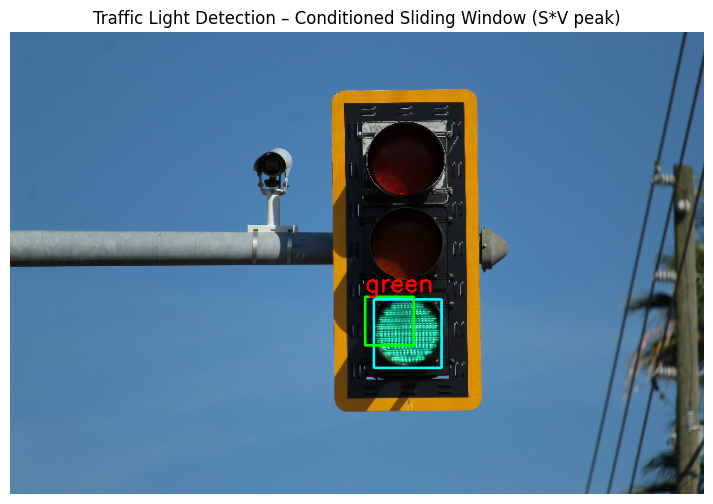

Chosen: green S= 176.0 V= 255.0 score= 41538.46484375 bbox= (419, 308, 78, 79, 4982)


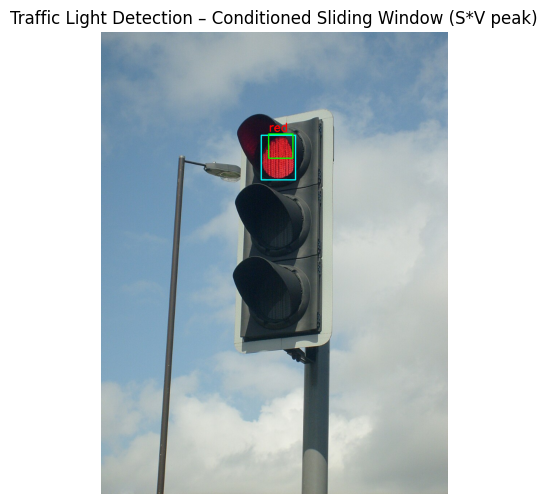

Chosen: red S= 215.0 V= 227.0 score= 44870.5 bbox= (369, 238, 79, 103, 6501)


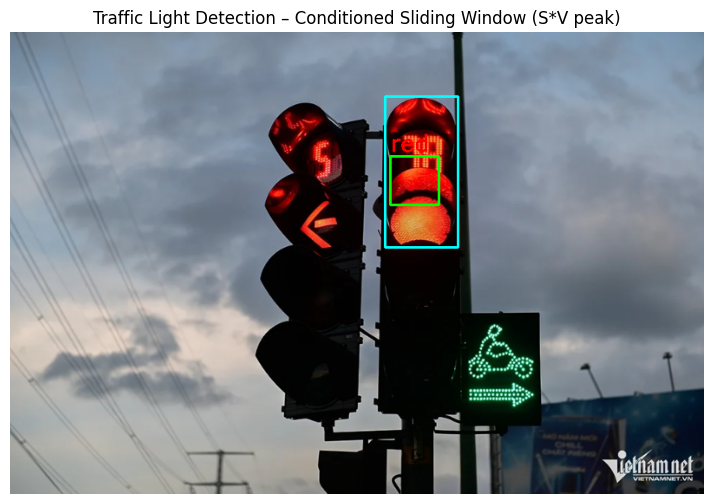

Chosen: red S= 255.0 V= 249.0 score= 62632.1640625 bbox= (432, 74, 84, 174, 10408)


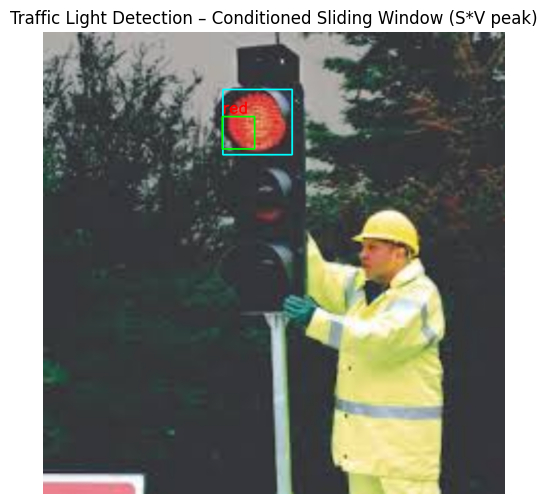

Chosen: red S= 205.0 V= 236.0 score= 46993.875 bbox= (311, 99, 120, 113, 10698)


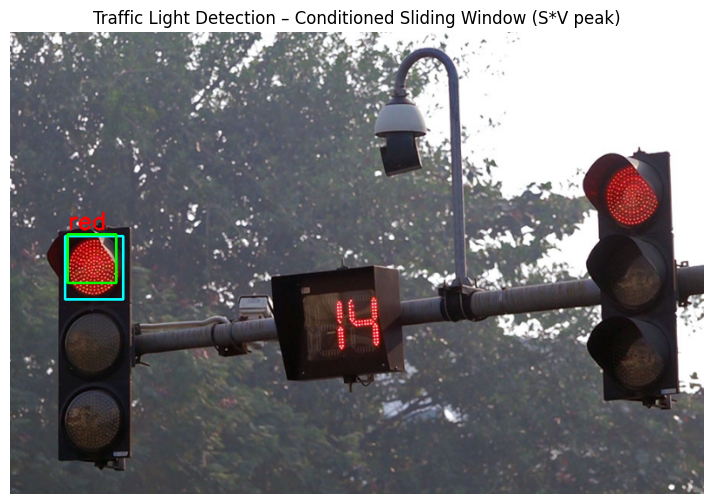

Chosen: red S= 215.0 V= 208.0 score= 43591.84375 bbox= (63, 235, 67, 73, 3848)


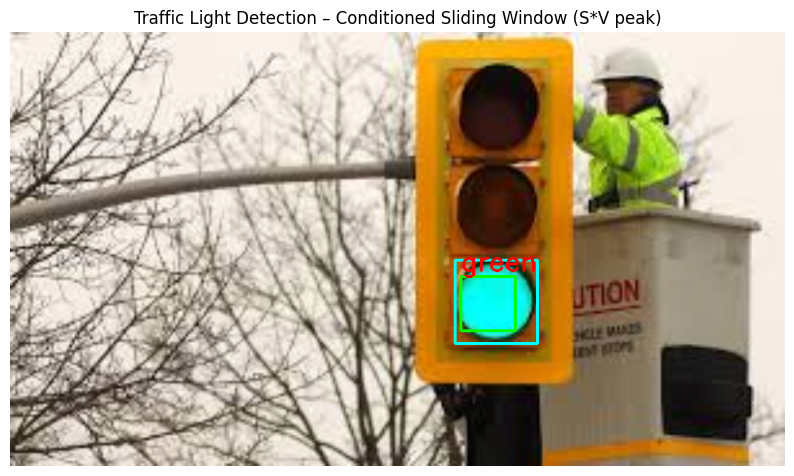

Chosen: green S= 254.0 V= 255.0 score= 64662.5546875 bbox= (459, 235, 85, 86, 6031)


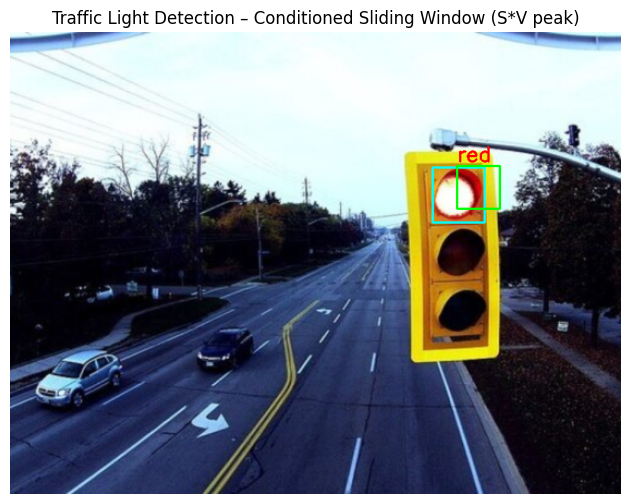

Chosen: red S= 248.0 V= 222.0 score= 51630.03515625 bbox= (553, 177, 68, 72, 2469)


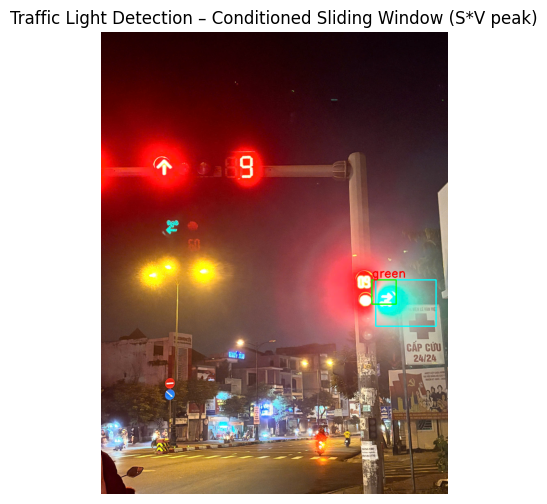

Chosen: green S= 255.0 V= 255.0 score= 64960.58984375 bbox= (633, 572, 139, 107, 10471)


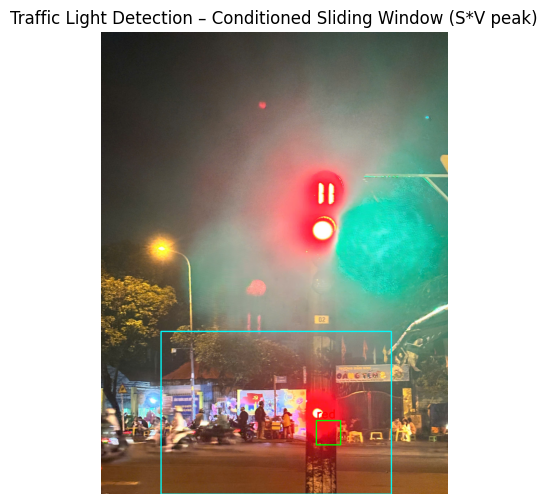

Chosen: red S= 242.0 V= 255.0 score= 36090.67265625 bbox= (138, 691, 531, 376, 103152)


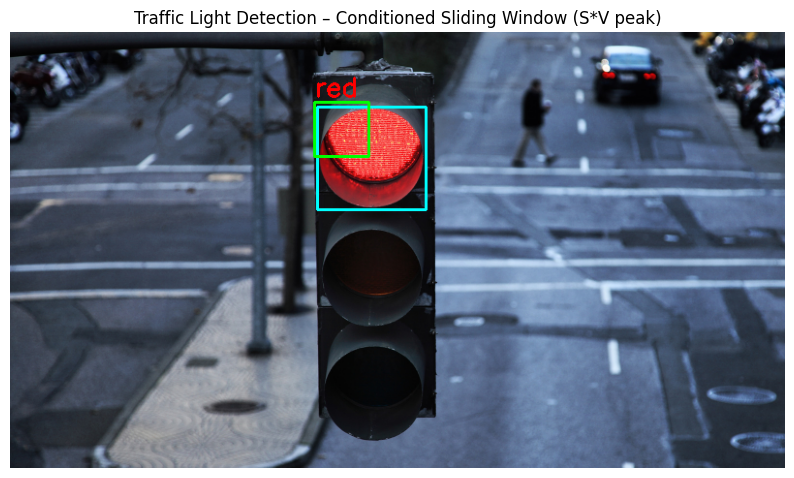

Chosen: red S= 170.0 V= 247.0 score= 46506.96484375 bbox= (317, 77, 112, 106, 9541)


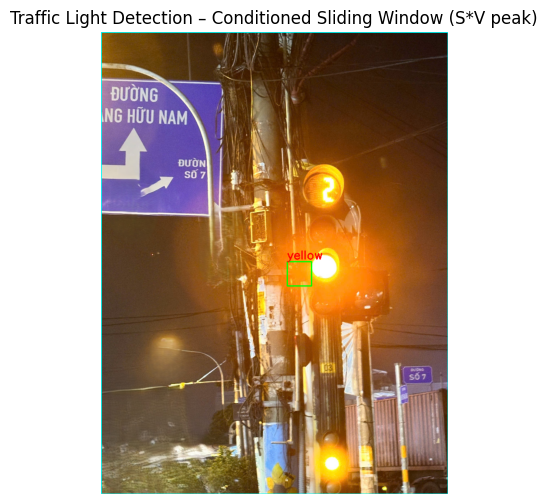

Chosen: yellow S= 255.0 V= 255.0 score= 39008.39296875 bbox= (0, 0, 800, 1067, 637588)


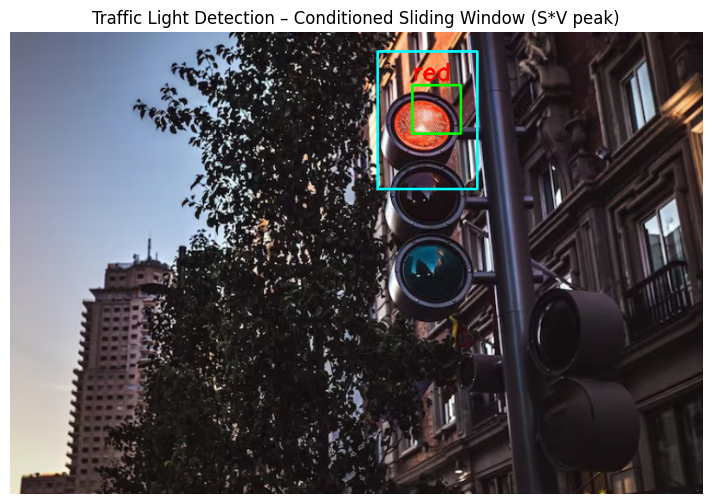

Chosen: red S= 242.0 V= 228.0 score= 49342.2578125 bbox= (424, 22, 115, 159, 7170)


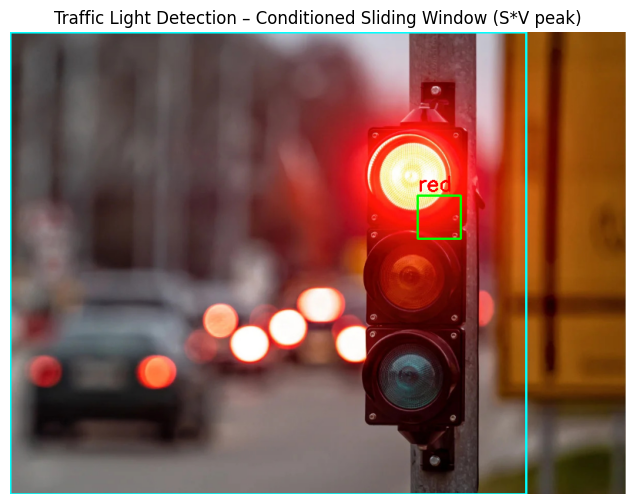

Chosen: red S= 250.0 V= 255.0 score= 37885.2421875 bbox= (0, 0, 670, 600, 217745)


In [20]:
# =========================
# FINAL STABLE DEMO (works in practice)
# Conditioned Sliding Window by "brightest colored pixel" (S*V)
# - Không cần threshold cứng kiểu v_abs_min/s_abs_min
# - Không phụ thuộc circularity/contour quá nhạy
# - Luôn ra box nếu trong ảnh có vùng màu đỏ/vàng/xanh đủ rõ
# =========================

import cv2
import numpy as np
import matplotlib.pyplot as plt

ID2NAME = {1: "green", 2: "red", 3: "yellow"}

def _make_hue_mask(hsv, color):
    H = hsv[..., 0]
    if color == "red":
        return ((H <= 10) | (H >= 160))
    if color == "yellow":
        return ((H >= 12) & (H <= 45))
    # green
    return ((H >= 35) & (H <= 95))

def _best_point_by_sv(hsv, hue_mask, y_top_ratio=0.92):
    """
    Chọn điểm mạnh nhất theo score = S*V trong vùng hue_mask.
    Có prior theo chiều dọc để tránh dính vùng dưới ảnh.
    """
    S = hsv[..., 1].astype(np.float32)
    V = hsv[..., 2].astype(np.float32)

    H, W = V.shape
    y_limit = int(H * y_top_ratio)

    # score map: S*V (0..65025)
    score = (S * V)
    score[~hue_mask] = 0.0
    score[y_limit:, :] = 0.0  # bỏ phần đáy ảnh để tránh kéo box lệch xuống

    # làm mượt để ổn định điểm peak
    score_blur = cv2.GaussianBlur(score, (0, 0), sigmaX=2.0)

    maxv = float(score_blur.max())
    if maxv <= 0:
        return None  # không có pixel nào hợp lệ

    y, x = np.unravel_index(np.argmax(score_blur), score_blur.shape)

    return (x, y, maxv, float(S[y, x]), float(V[y, x]))

def _bbox_from_cc(mask_bool, x, y):
    """
    Lấy bbox component chứa điểm (x,y) trong mask_bool.
    """
    m = (mask_bool.astype(np.uint8) * 255)
    kernel = np.ones((5, 5), np.uint8)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel)
    m = cv2.morphologyEx(m, cv2.MORPH_DILATE, kernel)

    num, labels, stats, _ = cv2.connectedComponentsWithStats((m > 0).astype(np.uint8), connectivity=8)
    if num <= 1:
        return None

    lab = labels[y, x]
    if lab == 0:
        return None

    x0, y0, w, h, area = stats[lab]
    return (int(x0), int(y0), int(w), int(h), int(area))

def demo_tl_conditioned_sw_svpeak(image_path, resize_w=640, win_size=48, debug=False):
    bgr = cv2.imread(image_path)
    if bgr is None:
        raise ValueError(f"Cannot read image: {image_path}")

    # resize
    scale = resize_w / bgr.shape[1]
    bgr = cv2.resize(bgr, None, fx=scale, fy=scale)

    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    vis = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # colors to check
    colors = [("red", 2), ("yellow", 3), ("green", 1)]

    best = None  # (score, cls, color_name, x,y, S,V, bbox)
    for cname, cls in colors:
        hm = _make_hue_mask(hsv, cname)

        # lọc nhẹ S/V để tránh sky noise nhưng KHÔNG quá chặt
        S = hsv[..., 1]
        V = hsv[..., 2]
        hm = hm & (S >= 40) & (V >= 40)

        pt = _best_point_by_sv(hsv, hm, y_top_ratio=0.92)
        if pt is None:
            continue

        x, y, sc, s_at, v_at = pt

        # bbox component quanh điểm peak
        bbox = _bbox_from_cc(hm, x, y)

        # nếu bbox quá to (dính khung) hoặc quá nhỏ, vẫn cho qua nhưng giảm điểm
        penalty = 0.0
        if bbox is not None:
            bx, by, bw, bh, barea = bbox
            img_area = vis.shape[0] * vis.shape[1]
            if barea > 0.03 * img_area:
                penalty += 0.4
            if barea < 60:
                penalty += 0.2

        final_score = sc * (1.0 - penalty)

        if (best is None) or (final_score > best[0]):
            best = (final_score, cls, cname, x, y, s_at, v_at, bbox)

    if best is None:
        plt.figure(figsize=(10, 6))
        plt.imshow(vis)
        plt.title("No colored peak found (try increase resize_w or relax S/V>=40)")
        plt.axis("off")
        plt.show()
        return

    final_score, cls, cname, x, y, s_at, v_at, bbox = best

    # sliding window đại diện quanh điểm peak
    xx = int(x - win_size // 2)
    yy = int(y - win_size // 2)
    xx = max(0, min(xx, vis.shape[1] - win_size))
    yy = max(0, min(yy, vis.shape[0] - win_size))

    # draw bbox component (cyan) nếu có
    if bbox is not None:
        bx, by, bw, bh, barea = bbox
        cv2.rectangle(vis, (bx, by), (bx + bw, by + bh), (0, 255, 255), 2)

    # draw sliding window (green)
    cv2.rectangle(vis, (xx, yy), (xx + win_size, yy + win_size), (0, 255, 0), 2)

    # label
    cv2.putText(
        vis,
        f"{ID2NAME[cls]}",
        (xx, max(0, yy - 6)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2
    )

    # show
    plt.figure(figsize=(10, 6))
    plt.imshow(vis)
    plt.title("Traffic Light Detection – Conditioned Sliding Window (S*V peak)")
    plt.axis("off")
    plt.show()

    if debug:
        print("Chosen:", cname, "S=", s_at, "V=", v_at, "score=", final_score, "bbox=", bbox)


# RUN DEMO
demo_img = r"C:\Users\PC\models\demo\eliobed-suarez-PN-YnI5stdQ-unsplash_e8ff418d-97fb-4e3c-a78c-8571b6b8e73b.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\Modern_British_LED_Traffic_Light.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\fdceb3c2065a4efa901855da21cd2ce3.webp"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\images.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\Den-Giao-Thong.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\images (1).jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\fe4bbe81600a40063594e597e00eb05b_XL.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\z7324240416321_c76e55b65c04165983e9a37b3243f69c.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\z7324240433275_f8ca493d53ea3a8626c48fb20609b683.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\l-intro-1706556583.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\z7324240377872_311be3167050f8b7d46bea38b69af15d.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\modern-traffic-light-showing-red-color-night-modern-city_657883-304.jpg"   
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)
demo_img = r"C:\Users\PC\models\demo\dde48427-4b52-46d0-81c2-91df594db64c-RED-LIGHT.jpg"
demo_tl_conditioned_sw_svpeak(demo_img, resize_w=800, win_size=56, debug=True)

